In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

### 1. Leitura e carregamento dos dados, agregando todos os meses

In [2]:
def read_all_csvs(path):
    df_list = []
    
    for arquivo in os.listdir(path):
        if arquivo.endswith('.csv'):
            filepath = os.path.join(path, arquivo)
            
            df_read = pd.read_csv(filepath, sep=';')
            df_read['valorMedida'] = df_read['valorMedida'].str.replace(',', '.').astype(float)
            df_read['datahora'] = pd.to_datetime(df_read['datahora'])

            df = pd.DataFrame()
            df['estacao'] = df_read['nomeEstacao']
            df['datahora'] = df_read['datahora']
            df['valor_mm'] = df_read['valorMedida']

            df = df.sort_values(by='datahora', ascending=True)
            df.set_index('datahora', inplace=True)
            
            df_list.append(df)

    # df = pd.concat(df_list, ignore_index=True)
    df = reduce(lambda left, right: pd.merge(left, right, how='outer', 
                                            left_on=['estacao', 'datahora', 'valor_mm'],
                                            right_on=['estacao', 'datahora', 'valor_mm']), 
                                            df_list)
    
    estacoes = df['estacao'].unique()

    series = []
    for estacao in estacoes:

        df_por_hora = df.loc[df['estacao'] == estacao]['valor_mm'].resample('H').mean()
        df_por_hora = df_por_hora.to_frame()
        df_por_hora.columns = ['valor_mm_' + str(estacao)]
        series.append(df_por_hora)

    df = reduce(lambda left, right: pd.merge(left, right, how='outer', 
                                                on='datahora'), 
                                                series)


    return df

In [3]:
df = read_all_csvs('./chuva_videira/')

In [4]:
# df = df.sort_values(by='datahora', ascending=True)
df.head()

valor_mm_Floresta  valor_mm_Oficina da Prefeitura  \
datahora                                                                 
2023-10-20 06:00:00                0.2                             0.1   
2023-10-20 07:00:00                NaN                             0.1   
2023-10-20 08:00:00                NaN                             0.0   
2023-10-20 09:00:00                NaN                             0.0   
2023-10-20 10:00:00                NaN                             0.0   

                     valor_mm_Aeroporto  valor_mm_Rio das Pedras  
datahora                                                          
2023-10-20 06:00:00            0.133333                      0.2  
2023-10-20 07:00:00            0.000000                      0.0  
2023-10-20 08:00:00            0.000000                      0.0  
2023-10-20 09:00:00            0.000000                      0.0  
2023-10-20 10:00:00            0.000000                      0.0

### 2. Exploração do dataset

Vamos ver a data de início e fim de coleta das estações:

In [5]:
print('De: ' + str(df.index.min()) + ' até: ' + str(df.index.max()))

De: 2023-08-01 00:00:00 até: 2024-01-31 23:00:00


Plotando alguns meses para analisar os dados:

Text(0.5, 1.0, 'Aeroporto')

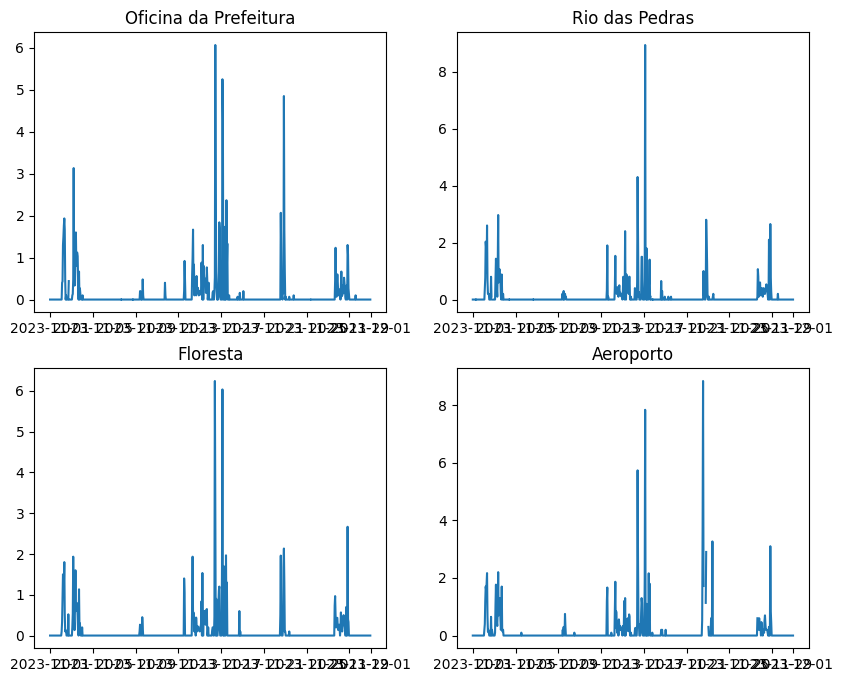

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

df_aux = df[df.index.month == 11]

axs[0, 0].plot(df_aux['valor_mm_Oficina da Prefeitura'])
axs[0, 0].set_title('Oficina da Prefeitura')

axs[0, 1].plot(df_aux['valor_mm_Rio das Pedras'])
axs[0, 1].set_title('Rio das Pedras')

axs[1, 0].plot(df_aux['valor_mm_Floresta'])
axs[1, 0].set_title('Floresta')

axs[1, 1].plot(df_aux['valor_mm_Aeroporto'])
axs[1, 1].set_title('Aeroporto')

Se variarmos os meses nas células acima, nota-se que as estações Floresta e Aeroporto possuem muitos dados faltantes. Vamos trabalhar com as outras duas.<br>

#### 2.1 Relação entre os dados

In [9]:
df.corr()

valor_mm_Floresta  \
valor_mm_Floresta                        1.000000   
valor_mm_Oficina da Prefeitura           0.574510   
valor_mm_Aeroporto                       0.725544   
valor_mm_Rio das Pedras                  0.764698   

                                valor_mm_Oficina da Prefeitura  \
valor_mm_Floresta                                     0.574510   
valor_mm_Oficina da Prefeitura                        1.000000   
valor_mm_Aeroporto                                    0.409077   
valor_mm_Rio das Pedras                               0.466427   

                                valor_mm_Aeroporto  valor_mm_Rio das Pedras  
valor_mm_Floresta                         0.725544                 0.764698  
valor_mm_Oficina da Prefeitura            0.409077                 0.466427  
valor_mm_Aeroporto                        1.000000                 0.781821  
valor_mm_Rio das Pedras                   0.781821                 1.000000

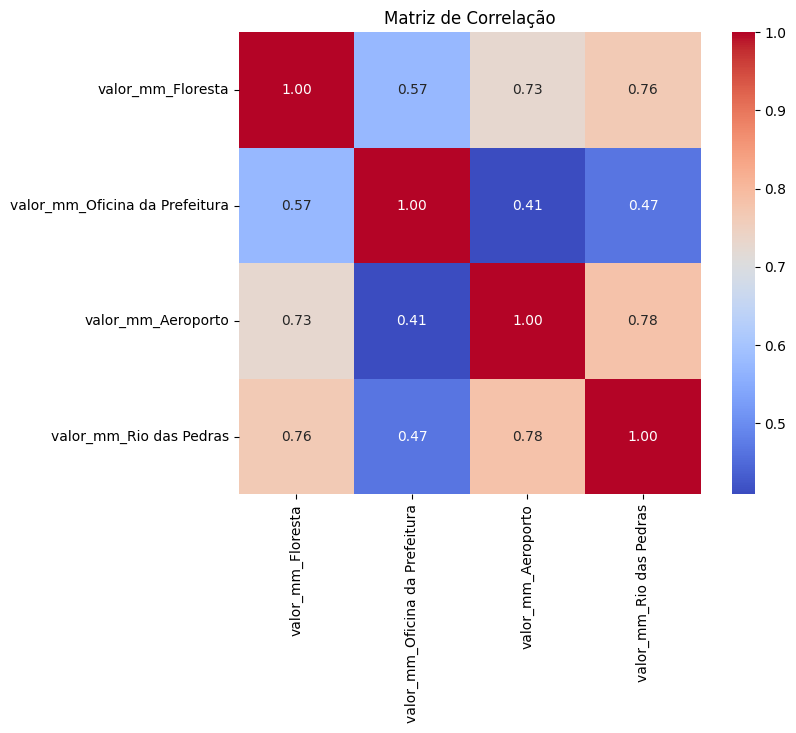

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlação')
plt.show()

In [12]:
df = df.sort_index(ascending=True)

Text(0.5, 1.0, 'Total Acumulado de Chuva (mm)')

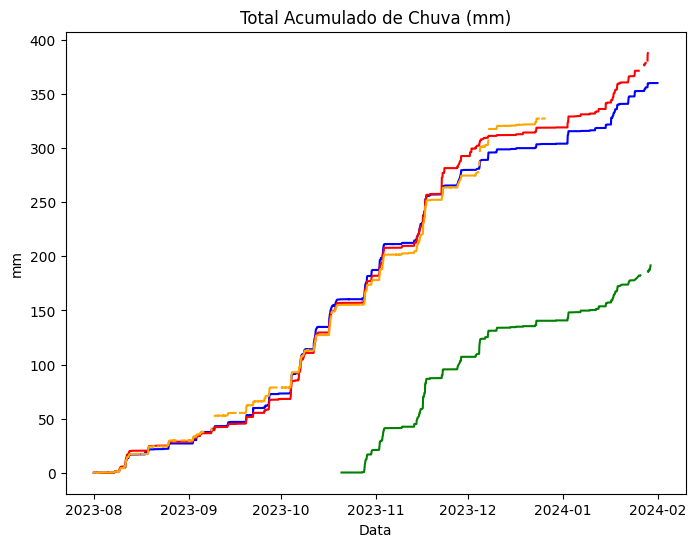

In [13]:
fig = plt.figure(figsize=(8, 6))

plt.plot(df['valor_mm_Rio das Pedras'].cumsum(), color='blue')
plt.plot(df['valor_mm_Aeroporto'].cumsum(), color='red')
plt.plot(df['valor_mm_Floresta'].cumsum(), color='green')
plt.plot(df['valor_mm_Oficina da Prefeitura'].cumsum(), color='orange')
plt.xlabel('Data')
plt.ylabel('mm')
plt.title('Total Acumulado de Chuva (mm)')

No gráfico acima nota-se a falta de dados. Algumas séries (Oficina da Prefeitura e Floresta) possuem muitos dados faltantes, e usar técnicas para tratá-los é bastante difícil. <br>

Vamos nos ater às séries restantes e tratar os dados NaN.

In [15]:
df = df.drop(columns=['valor_mm_Oficina da Prefeitura', 'valor_mm_Floresta'])
df.head()

valor_mm_Aeroporto  valor_mm_Rio das Pedras
datahora                                                        
2023-08-01 00:00:00                 0.0                      0.0
2023-08-01 01:00:00                 0.0                      0.0
2023-08-01 02:00:00                 0.0                      0.0
2023-08-01 03:00:00                 0.0                      0.0
2023-08-01 04:00:00                 0.0                      0.0

In [16]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4258 entries, 2023-08-01 00:00:00 to 2024-01-31 01:00:00
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   valor_mm_Aeroporto       4258 non-null   float64
 1   valor_mm_Rio das Pedras  4258 non-null   float64
dtypes: float64(2)
memory usage: 99.8 KB


In [17]:
df.corr()

valor_mm_Aeroporto  valor_mm_Rio das Pedras
valor_mm_Aeroporto                 1.000000                 0.781821
valor_mm_Rio das Pedras            0.781821                 1.000000

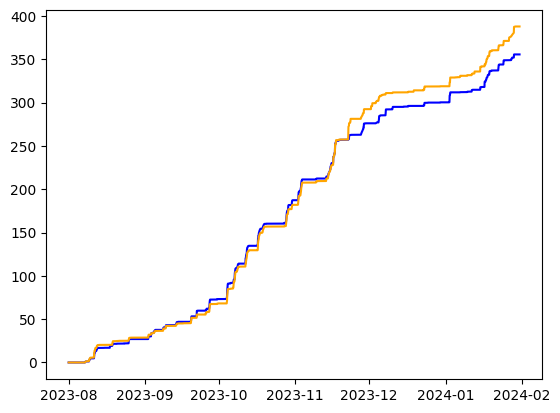

In [19]:
plt.plot(df['valor_mm_Rio das Pedras'].cumsum(), color='blue')
plt.plot(df['valor_mm_Aeroporto'].cumsum(), color='orange')

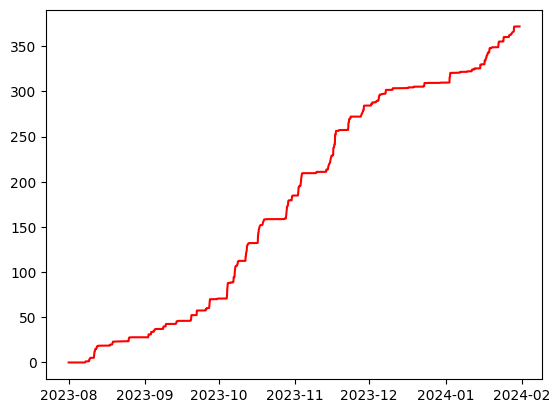

In [21]:
plt.plot(df['valor_mm_videira'].cumsum(), color='red')

In [20]:
df['valor_mm_videira'] = (df['valor_mm_Aeroporto'] + df['valor_mm_Rio das Pedras'])/2

In [ ]:
df.groupby(df.index, )

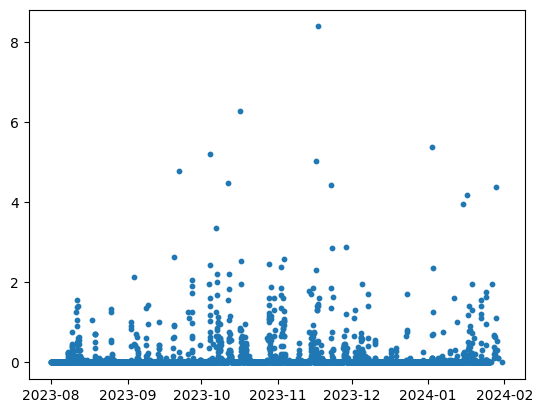

In [24]:
plt.scatter(df.index, df['valor_mm_videira'], s=10)

In [31]:
df_videira = df['valor_mm_videira']

#### Pegando os dados de chuva das estações telemétricas

In [25]:
def get_rain_station(url):
    
    df = pd.read_csv(url)
    df = df.drop(columns=['Nível adotado (cm)', 'Vazão (m³/s)',	'Bateria (V)',	'Temp. Interna (ºC)'])
    df.columns = ['datahora', 'valor_mm']
    df['datahora'] = pd.to_datetime(df['datahora'])
    df.set_index('datahora', inplace=True)
    df = df.sort_index(ascending=True)

    return df

In [26]:
cc = get_rain_station('raw_data/estacoes/cacador_chuva.csv')
rda = get_rain_station('raw_data/estacoes/rda_chuva_nivel_vazao.csv')
tg = get_rain_station('raw_data/estacoes/tangara_montante_chuva_nivel_vazao.csv')

/tmp/ipykernel_31196/4036642453.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datahora'] = pd.to_datetime(df['datahora'])
/tmp/ipykernel_31196/4036642453.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datahora'] = pd.to_datetime(df['datahora'])
/tmp/ipykernel_31196/4036642453.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datahora'] = pd.to_datetime(df['datahora'])


In [32]:
df_rain = pd.merge(pd.merge(cc, tg, how='outer', on='datahora', suffixes=['_cacador', '_tangara']), rda, on='datahora')
df_rain.columns = ['valor_mm_cacador',	'valor_mm_tangara',	'valor_mm_rda']
df_rain.head()

valor_mm_cacador  valor_mm_tangara  valor_mm_rda
datahora                                                             
2023-08-27 11:00:00               0.0               0.0           0.0
2023-08-27 12:00:00               0.0               0.0           0.0
2023-08-27 13:00:00               0.0               0.0           0.0
2023-08-27 14:00:00               0.0               0.0           0.0
2023-08-27 15:00:00               0.0               0.0           0.0

Agora vamos agregar o dataframe de Videira e finalmente salvar o arquivo em parquet.

In [33]:
df_rain_final = pd.merge(df_rain, df_videira, on='datahora')
df_rain_final.head()

valor_mm_cacador  valor_mm_tangara  valor_mm_rda  \
datahora                                                                
2023-08-27 11:00:00               0.0               0.0           0.0   
2023-08-27 12:00:00               0.0               0.0           0.0   
2023-08-27 13:00:00               0.0               0.0           0.0   
2023-08-27 14:00:00               0.0               0.0           0.0   
2023-08-27 15:00:00               0.0               0.0           0.0   

                     valor_mm_videira  
datahora                               
2023-08-27 11:00:00               0.0  
2023-08-27 12:00:00               0.0  
2023-08-27 13:00:00               0.0  
2023-08-27 14:00:00               0.0  
2023-08-27 15:00:00               0.0

In [42]:
df_rain_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3141 entries, 2023-08-27 11:00:00 to 2024-01-05 01:00:00
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_mm_cacador  2668 non-null   float64
 1   valor_mm_tangara  2985 non-null   float64
 2   valor_mm_rda      2679 non-null   float64
 3   valor_mm_videira  3141 non-null   float64
dtypes: float64(4)
memory usage: 122.7 KB


In [46]:
df_rain_final = df_rain_final.dropna()

In [47]:
df_rain_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2510 entries, 2023-08-27 11:00:00 to 2024-01-31 01:00:00
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_mm_cacador  2510 non-null   float64
 1   valor_mm_tangara  2510 non-null   float64
 2   valor_mm_rda      2510 non-null   float64
 3   valor_mm_videira  2510 non-null   float64
dtypes: float64(4)
memory usage: 98.0 KB


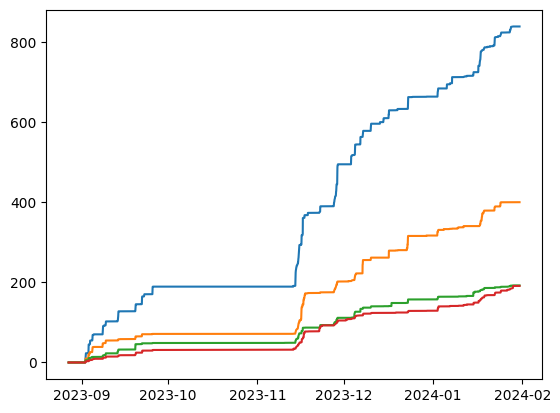

In [52]:
plt.plot(df_rain_final.cumsum())

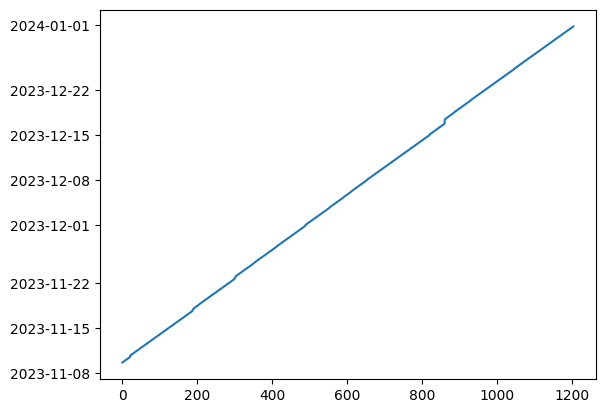

In [84]:
plt.plot(df_rain_final.index)

In [83]:
df_rain_final = df_rain_final[df_rain_final.index < 11].sort_index(ascending=True)

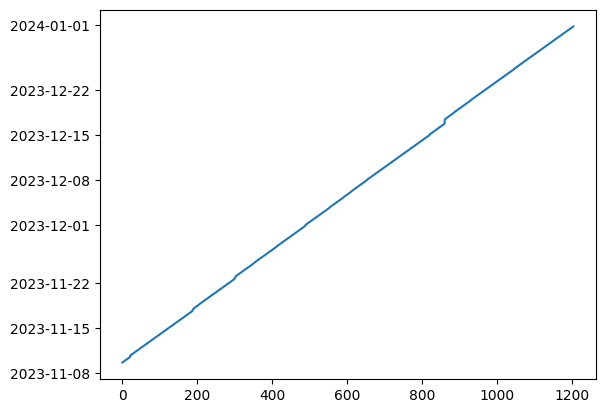

In [82]:
plt.plot(df_rain_final[(df_rain_final.index.month >= 11) & (df_rain_final.index < pd.to_datetime('2024-02-01'))].sort_index(ascending=True).index)